# Exploring UMAP on a graph - Part 2 - Adjacency as Similarity

Towards [Experiment #2: Evaluate UMAP(+HDBSCAN) as a graph embedding(clustering) algorithm](https://github.com/acwooding/HighDimensionalClustering/wiki/Experiments-to-Try). All notation is as in that post. 

Moving on from the complete graph example, let's more generally consider what happens when we consider two nodes similar if they are adjacent aka. give distance 1 when there is an edge and otherwise distance is $\infty$ (often using 1000 instead of $\infty$ since the precomputed code path doesn't take sparse matrices).

**Questions**:
* What structures are preserved from $X$ to $V(X)$ when using adjacency as similarity? What is not preserved?
* What is UMAP(+HDBSCAN) *doing* as a graph embedding (clustering) algorithm with this metric?
* It seems like the $k$ relative to the degree distribution should matter somehow...quantify this?

**Summary of Takeaways**:
* $k$ acts as a threshold for treating high degree nodes (degree > $k$) different than lower degree nodes. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
import scipy
import pandas as pd

import igraph as ig

from IPython.core.display import display, SVG

sns.set()

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Some helper functions to access $U(X)$ and $V(X)$

In [4]:
from src.custom.utils import get_graph_UX, get_VX_from_UX, adjacency_to_distance_matrix

# Small Toy Example

Let's look at what happens to cliques as $k$ varies with a small toy example. 

Let $n$ be the number of nodes in our graph $X$

In [5]:
n = 20

Create the adjacency matrix $M$ of a graph $X$

In [6]:
M = np.array([[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 
              [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], 
              [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], 
              [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1], 
              [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0], 
              [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], 
              [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], 
              [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], 
              [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], 
              [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], 
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], 
              [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1], 
              [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1], 
              [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], 
              [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], 
              [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1], 
              [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]])

In [7]:
G = ig.Graph.Weighted_Adjacency(M, 'undirected')

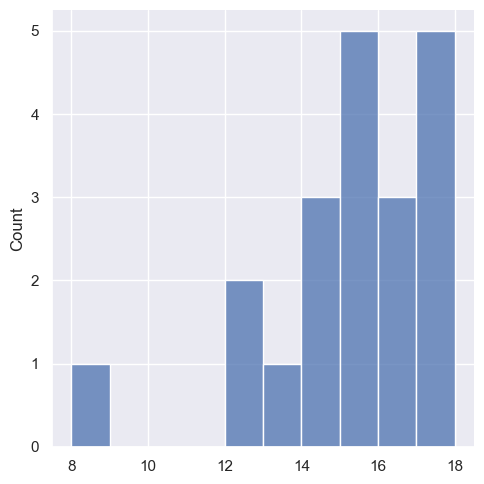

In [8]:
sns.displot(G.degree(), bins=10);

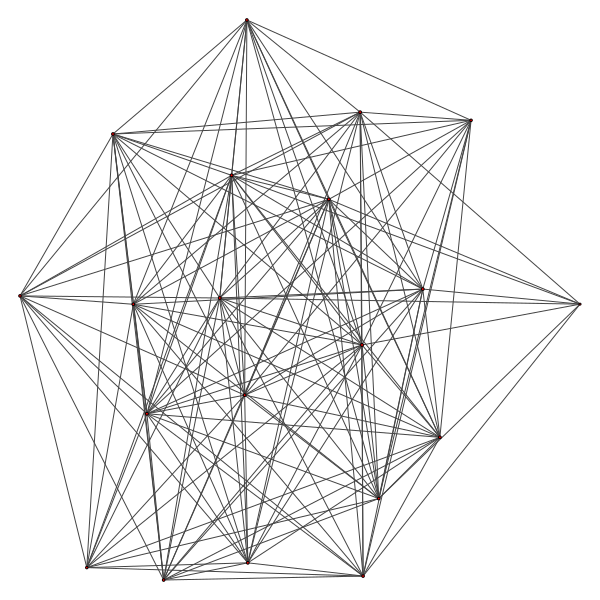

In [9]:
ig.plot(G, vertex_size=np.log(G.vs.degree()))

## Get $U(X)$

Some fixed parameters

In [10]:
random_state = 42
metric = 'precomputed'

Let's add some noise to the distances to simulate randomly choosing the $k^{th}$ neighbour in a tie-break situation and turning the matix into a sparse matrix to give distance 1 when there is an edge and otherwise (using 1000 instead of $\infty$ since the precomputed code path doesn't take sparse matrices)

In [11]:
N = adjacency_to_distance_matrix(M)

Let's start with $k=7$, about half of the mean degree of $X$.

In [12]:
k = 7

In [13]:
ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

In [14]:
np.unique(ux.indegree(), return_counts=True)

(array([2, 3, 4, 5, 6, 7, 8, 9]), array([1, 1, 1, 1, 1, 4, 7, 4]))

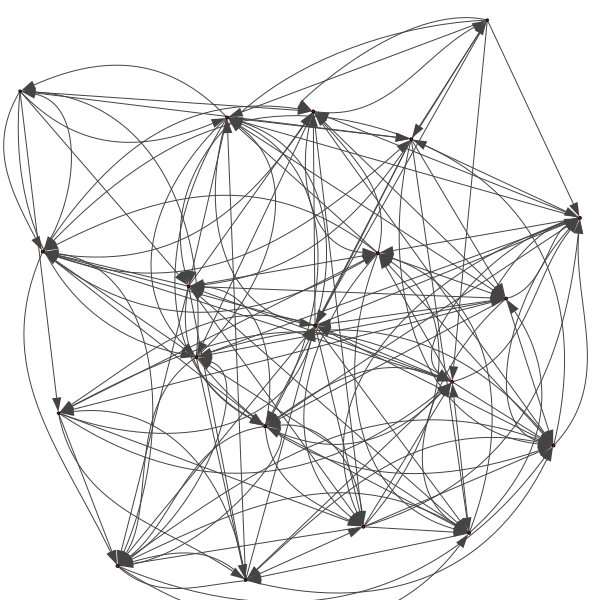

In [15]:
ig.plot(ux, vertex_size=np.log(ux.vs.degree()))

And $V(X)$ (assuming fuzzy union)

In [16]:
set_op_mix_ratio = 1.0
vx = get_VX_from_UX(ux.get_adjacency_sparse(), set_op_mix_ratio)

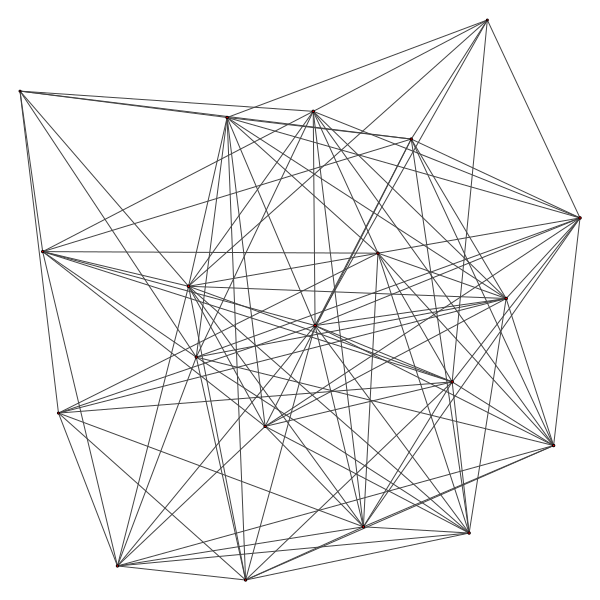

In [17]:
ig.plot(vx, vertex_size=np.log(vx.vs.degree()))

Let's look at how many edges are preserved:

In [18]:
M.sum()

296

In [19]:
vx.get_adjacency_sparse().sum()

212

Double check we don't have any new edges

In [20]:
(M - vx.get_adjacency_sparse()).sum()

84

Compare degree distributions

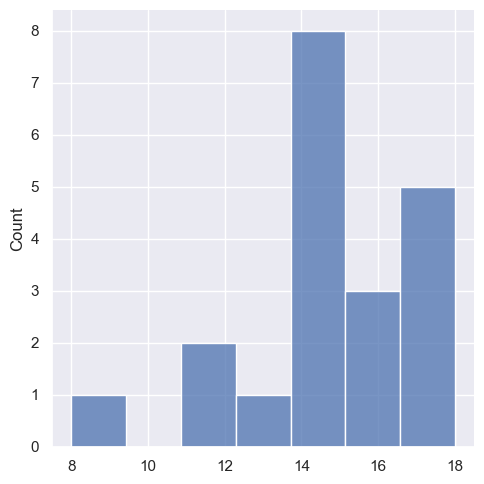

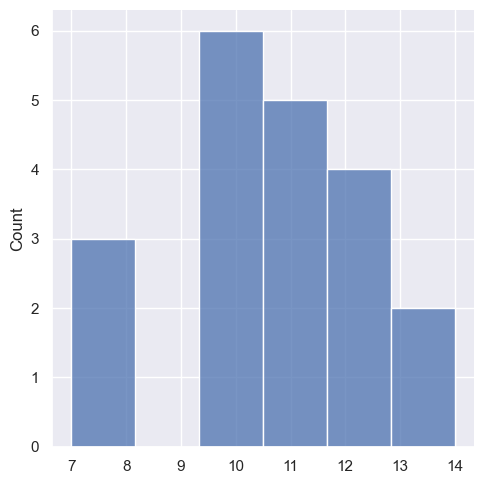

In [21]:
sns.displot(G.degree())
sns.displot(vx.degree());

Look at the number of cliques preserved

In [22]:
size_max_clique = max([len(x) for x in G.maximal_cliques()])

In [23]:
for k in range(3, size_max_clique + 1):
    print(f'number of {k}-cliques:, {len(G.cliques(min=k, max=k))}')

number of 3-cliques:, 550
number of 4-cliques:, 1149
number of 5-cliques:, 1419
number of 6-cliques:, 1055
number of 7-cliques:, 464
number of 8-cliques:, 111
number of 9-cliques:, 11


In [24]:
for m in range(3, k):
    print(f'number of {m}-cliques:, {len(vx.cliques(min=m, max=m))}')

number of 3-cliques:, 183
number of 4-cliques:, 105
number of 5-cliques:, 22
number of 6-cliques:, 0
number of 7-cliques:, 0
number of 8-cliques:, 0


Assuming fuzzy union, here's the 2D embedding we get:

In [25]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(N)
G.vs['layout'] = X_rep.embedding_

Here's a plot of the original graph using the UMAP node embedding placement (the graph using umap layout has red nodes, and the igraph layout has green nodes). 

It seems to do a decent job.

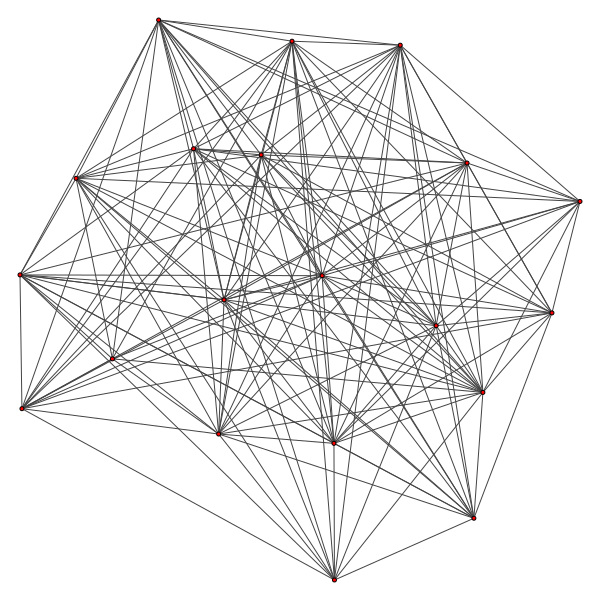

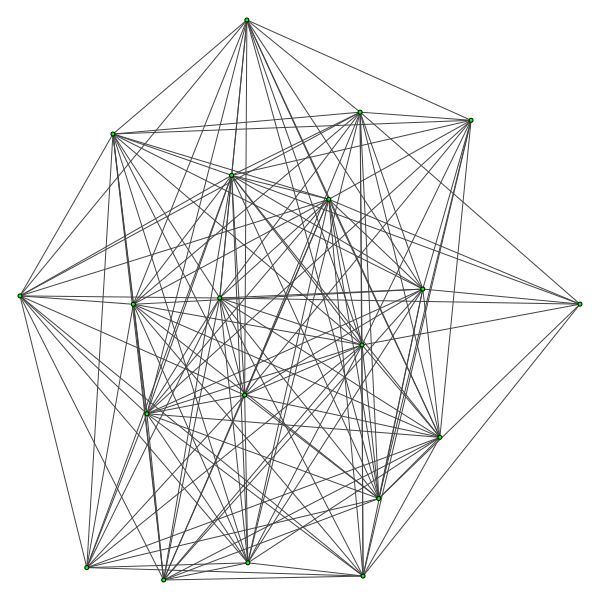

In [26]:
display(SVG(ig.plot(G, layout = G.vs['layout'], vertex_size=4, vertex_color='red')._repr_svg_()[0]))
display(SVG(ig.plot(G, vertex_size=4, vertex_color='green')._repr_svg_()[0]))

# Now with varying $k$

Let's see how far we have to go with $k$ so that $V(X)$ is all of $X$.

In [27]:
num_edges = M.sum()
for k in range(3, max(G.degree())):
    print(f'\n{k} \n ----------------------')
    ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)
    vx = get_VX_from_UX(ux.get_adjacency_sparse())
    is_identity = (vx.get_adjacency_sparse().todense() == M).all()
    print(f'Identity from X to V(X): {is_identity}')
    if not is_identity:
        print(f'proportion of edges preserved: {vx.get_adjacency_sparse().sum()/num_edges}')
        for j in range(3, min((k + 2), size_max_clique)):
            print(f'number of {j}-cliques in V(X): {len(vx.cliques(min=j, max=j))}')


3 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.3783783783783784
number of 3-cliques in V(X): 23
number of 4-cliques in V(X): 1

4 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.47297297297297297
number of 3-cliques in V(X): 50
number of 4-cliques in V(X): 8
number of 5-cliques in V(X): 1

5 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.5608108108108109
number of 3-cliques in V(X): 90
number of 4-cliques in V(X): 30
number of 5-cliques in V(X): 3
number of 6-cliques in V(X): 0

6 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.6554054054054054
number of 3-cliques in V(X): 144
number of 4-cliques in V(X): 69
number of 5-cliques in V(X): 11
number of 6-cliques in V(X): 0
number of 7-cliques in V(X): 0

7 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.7162162162162162
number of 3-

Note that once $k$ was close enought to the max degree we recovered the entirety of the initial graph with $V(X)$. 

# A Slightly Bigger Toy Example

Let's look at a graph with 100 nodes and roughly 70 edges per node. 

In [28]:
n = 100

In [29]:
H = ig.Graph.Weighted_Adjacency(np.random.rand(n,n).round(), 'directed')
G = H.simplify().as_undirected()
M = G.get_adjacency_sparse().todense()

In [30]:
N = adjacency_to_distance_matrix(M)

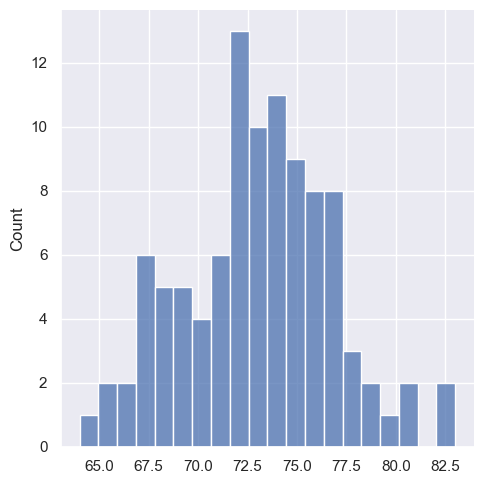

In [31]:
sns.displot(G.degree(), bins=20);

Compute all the steps for varying $k$. Note how far we have to go to get to the identity map from $X$ to $V(X)$.

In [32]:
max_clique_size = max(np.unique([len(x) for  x in G.maximal_cliques()]))
max_clique_size

16

In [33]:
k_n_cliques = {}
ux_graphs = {}
vx_graphs = {}
embeddings = {}
num_edges = M.sum()

for k in np.arange(3, max(G.degree()), 10):
    print(f'\n{k} \n ----------------------')
    ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)
    ux_graphs[k] = ux
    set_op_mix_ratio = 1.0
    vx = get_VX_from_UX(ux.get_adjacency_sparse(), set_op_mix_ratio)
    is_identity = (vx.get_adjacency_sparse().todense() == M).all()
    X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(N)
    vx.vs['layout'] = X_rep.embedding_
    vx_graphs[k] = vx
    embeddings[k] = X_rep
    print(f'Identity from X to V(X): {is_identity}')
    if not is_identity:
        print(f'proportion of edges preserved: {vx.get_adjacency_sparse().sum()/num_edges}')

        d = {}
        for j in range(3, max_clique_size+1):
            d[j] = len(vx.cliques(min=j, max=j))
        k_n_cliques[k] = d


3 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.08084406686763497

13 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.3252946012606193

23 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.5319265552206084

33 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.6966292134831461

43 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.825979720471362

53 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.926829268292683

63 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.9810907097835023

73 
 ----------------------
Identity from X to V(X): True


## Preserving Cliques

Let's take a look at how many cliques are preserved of different sizes while varying `n_neighbors`

In [34]:
max_clique_size = max(np.unique([len(x) for  x in G.maximal_cliques()]))
max_clique_size

16

In [36]:
n_cliques = {}
for j in range(3, max_clique_size+1):
    n_cliques[j] = len(G.cliques(min=j, max=j))
    print(f'number of {j}-cliques in G: {n_cliques[j]}')

number of 3-cliques in G: 64667
number of 4-cliques in G: 625052
number of 5-cliques in G: 3508894
number of 6-cliques in G: 11899921
number of 7-cliques in G: 25050585
number of 8-cliques in G: 33397732
number of 9-cliques in G: 28644800
number of 10-cliques in G: 15998262
number of 11-cliques in G: 5861683
number of 12-cliques in G: 1407741
number of 13-cliques in G: 218598
number of 14-cliques in G: 21295
number of 15-cliques in G: 1211
number of 16-cliques in G: 30


In [38]:
proportion = {}
for j in range(3, max_clique_size+1):
    d = {}
    for a in np.arange(3, max(G.degree())-10, 10):
        d[a] = int(k_n_cliques[a][j] / n_cliques[j] * 100)
    d[83] = 100 # add for completion
    proportion[j]= d

In [39]:
df = pd.DataFrame(proportion)

In [40]:
df

,3,4,5,6,7,8,9,10,11,12,13,14,15,16
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,3,0,0,0,0,0,0,0,0,0,0,0,0,0
23,14,2,0,0,0,0,0,0,0,0,0,0,0,0
33,33,10,2,0,0,0,0,0,0,0,0,0,0,0
43,55,30,13,4,1,0,0,0,0,0,0,0,0,0
53,79,62,44,29,17,9,4,1,0,0,0,0,0,0
63,94,88,80,72,62,52,43,34,27,21,16,12,11,16
83,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [ ]:
df.plot(xlabel='n_neighbors', ylabel='% of cliques');

This seems to make sense when we review the degree distribution of the graph $X$ (which is more or less normally distributed). And because of proportionally keeping more edges from low degree nodes (where low degree is defined by degree less than `n_neighbors`, we see that the larger cliques take a while to get preserved.

In [ ]:
degree = G.degree()
mean = np.mean(degree)
print(f'mean: {mean}, variance:{np.var(degree)}')

In particular, when `n_neighbors` hits the mean most of the edges from the original graph $X$ will be in $V(X)$. 

The degree distribution of $V(X)$ stays normal, and the mean and variance in the degree distribution grows as $k$ grows. 

In [ ]:
deg = {}
for i, a in enumerate(np.arange(3, max(G.degree())-10, 10)):
    degree = vx_graphs[a].degree()
    mean = np.mea n(degree)
    print(f'{a}:, mean: {mean}, variance:{np.var(degree)}')
    deg[a] = degree - mean

This suggests (although by no surprise) a relationship between the number of cliques preserved, `n_neighbors` and the degree distribution of the graph. Because we're choosing the adjacency as similarity, we can think of what we're doing as preserving adjacency, which should also preserve something of the degree distribution. For low degree nodes (nodes with degree less than $k$), the local neighbourhood is preserved exactly. However, connections between high degree nodes (degree greater than $k$) get thinned, as $U(X)$ only keeps $k$ outgoing edges for each high degree node. 

Time to look at something a little bit different....